In [1]:
import re
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Function to load, interpolate data to a common set of steps, and calculate average, min, and max
def load_interpolate_and_calculate_range(files, common_steps, window_size=-1):
    if not files:
        raise ValueError('No files found for the given pattern.')
        
    interpolated_data = []
    for file in files:
        df = pd.read_csv(file)
        interpolated_df = pd.DataFrame({'Step': common_steps})
        interpolated_df['Value'] = np.interp(common_steps, df['Step'], df['Value'])
        if window_size > 0:
            interpolated_df['Value'] = interpolated_df['Value'].rolling(window=window_size, min_periods=1).mean()
        interpolated_data.append(interpolated_df)
        
    combined_df = pd.concat(interpolated_data)
    average_df = combined_df.groupby('Step').mean().reset_index()
    min_df = combined_df.groupby('Step').min().reset_index()
    max_df = combined_df.groupby('Step').max().reset_index()
    
    return average_df, min_df, max_df

In [3]:
# Define the file paths for PPO and DQN
ppo_evaluation_files = glob.glob('data/LunarLander-v2/ppo/evaluation/*-tag-Evaluation_AverageEvaluationReturn.csv')
ppo_training_files = glob.glob('data/LunarLander-v2/ppo/training/*-tag-Training_AverageTrainingReturn.csv')
dqn_evaluation_files = glob.glob('data/LunarLander-v2/dqn/evaluation/*-tag-Evaluation_AverageEvaluationReturn.csv')
dqn_training_files = glob.glob('data/LunarLander-v2/dqn/training/*-tag-Training_AverageTrainingReturn.csv')

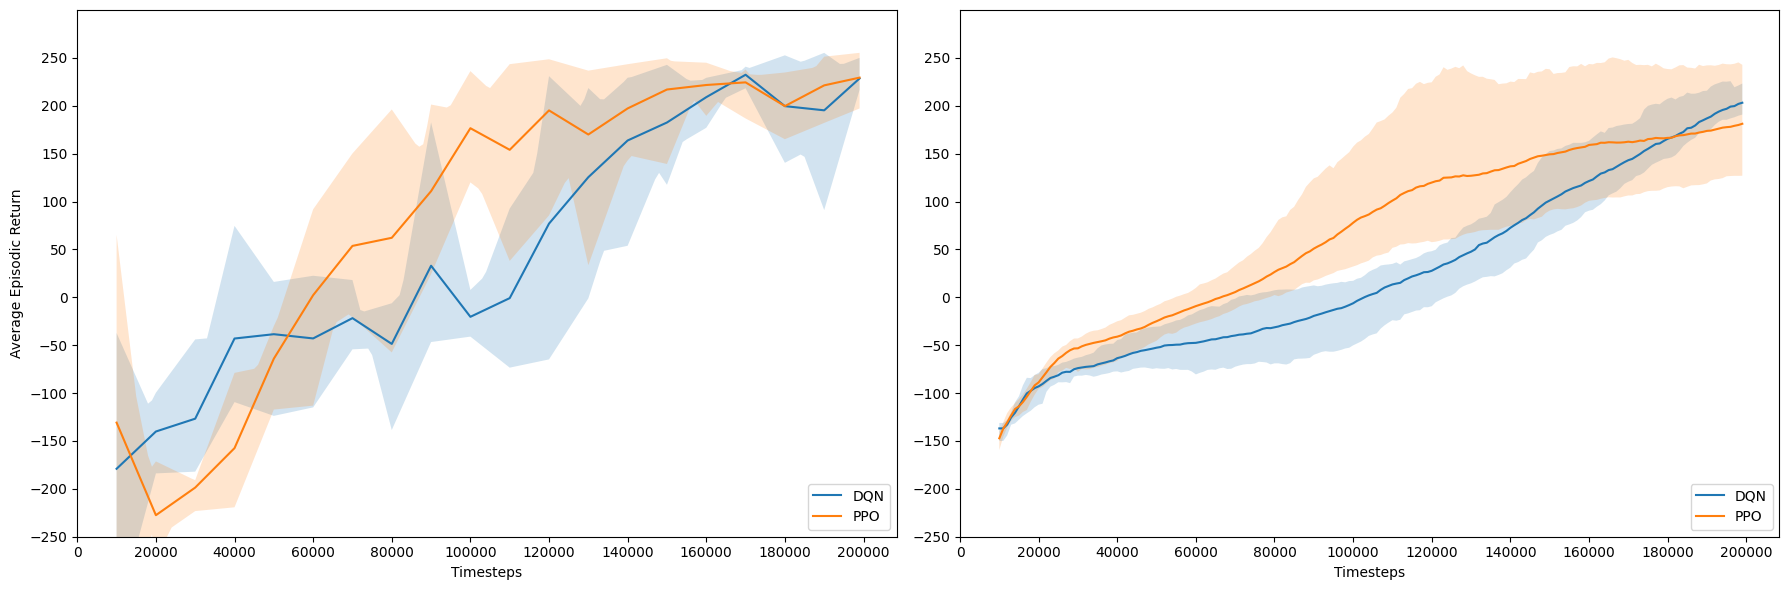

In [16]:
# Define a common set of steps for interpolation
common_steps = np.arange(10000, 200000, 1000)
window_size = -1

# Load, interpolate, and calculate range for PPO and DQN evaluation data
ppo_avg_eval, ppo_min_eval, ppo_max_eval = load_interpolate_and_calculate_range(ppo_evaluation_files, common_steps, window_size=window_size)
dqn_avg_eval, dqn_min_eval, dqn_max_eval = load_interpolate_and_calculate_range(dqn_evaluation_files, common_steps, window_size=window_size)

# Load, interpolate, and calculate range for PPO and DQN training data
ppo_avg_train, ppo_min_train, ppo_max_train = load_interpolate_and_calculate_range(ppo_training_files, common_steps)
dqn_avg_train, dqn_min_train, dqn_max_train = load_interpolate_and_calculate_range(dqn_training_files, common_steps)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot average with range for evaluation data
ax1.plot(dqn_avg_eval['Step'], dqn_avg_eval['Value'], label='DQN')
ax1.fill_between(dqn_avg_eval['Step'], dqn_min_eval['Value'], dqn_max_eval['Value'], alpha=0.2)

ax1.plot(ppo_avg_eval['Step'], ppo_avg_eval['Value'], label='PPO')
ax1.fill_between(ppo_avg_eval['Step'], ppo_min_eval['Value'], ppo_max_eval['Value'], alpha=0.2)

ax1.set_xlabel('Timesteps')
ax1.set_ylabel('Average Episodic Return')
ax1.legend(loc='lower right')
ax1.set_xticks(np.arange(0, 210000, 20000))
ax1.set_yticks(np.arange(-250, 300, 50))
ax1.set_ylim(-250, 300)

# Plot average with range for training data
ax2.plot(dqn_avg_train['Step'], dqn_avg_train['Value'], label='DQN')
ax2.fill_between(dqn_avg_train['Step'], dqn_min_train['Value'], dqn_max_train['Value'], alpha=0.2)

ax2.plot(ppo_avg_train['Step'], ppo_avg_train['Value'], label='PPO')
ax2.fill_between(ppo_avg_train['Step'], ppo_min_train['Value'], ppo_max_train['Value'], alpha=0.2)

ax2.set_xlabel('Timesteps')
ax2.legend(loc='lower right')
ax2.set_xticks(np.arange(0, 210000, 20000))
ax2.set_yticks(np.arange(-250, 300, 50))
ax2.set_ylim(-250, 300)

plt.tight_layout()
plt.savefig('figures/comparison.png', dpi=300)
plt.show()

In [5]:
# Define the file paths for PPO and DQN
dqn_eps_len_files = glob.glob('data/LunarLander-v2/dqn/eps_len/*-tag-Training_AverageEpisodeLength.csv')
ppo_eps_len_files = glob.glob('data/LunarLander-v2/ppo/eps_len/*-tag-Training_AverageEpisodeLength.csv')

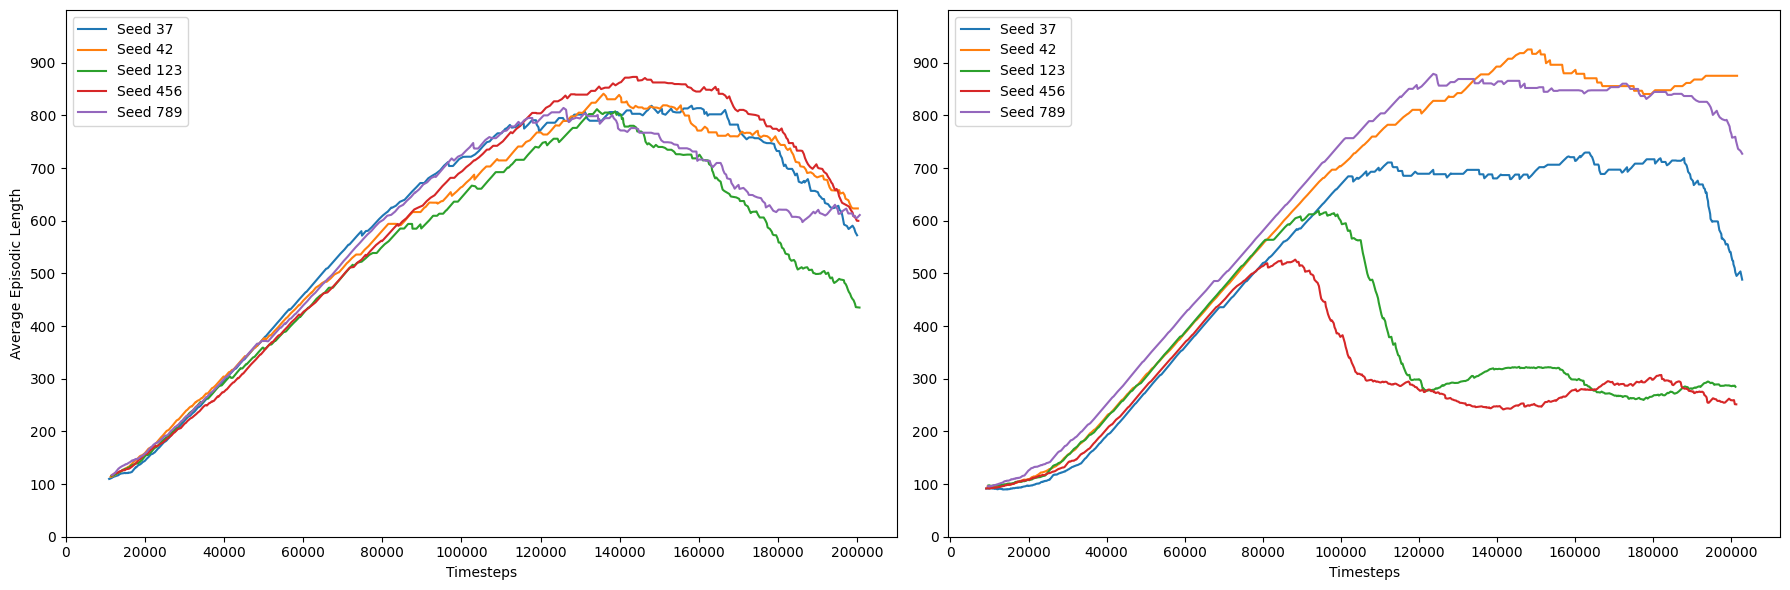

In [17]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

for file in sorted(dqn_eps_len_files, key=lambda f: int(re.search(r'seed_(\d+)', f).group(1))):
    data = pd.read_csv(file)
    seed = int(re.search(r'seed_(\d+)', file).group(1))
    ax1.plot(data['Step'], data['Value'], label=f'Seed {seed}')
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('Average Episodic Length')
    ax1.legend(loc='upper left')
    ax1.set_xticks(np.arange(0, 210000, 20000))
    ax1.set_yticks(np.arange(0, 1000, 100))
    ax1.set_ylim(0, 1000)

for file in sorted(ppo_eps_len_files, key=lambda f: int(re.search(r'seed_(\d+)', f).group(1))):
    data = pd.read_csv(file)
    seed = int(re.search(r'seed_(\d+)', file).group(1))
    ax2.plot(data['Step'], data['Value'], label=f'Seed {seed}')
    ax2.set_xlabel('Timesteps')
    ax2.legend(loc='upper left')
    ax2.set_xticks(np.arange(0, 210000, 20000))
    ax2.set_yticks(np.arange(0, 1000, 100))
    ax2.set_ylim(0, 1000)

plt.tight_layout()
plt.savefig('figures/avg_eps_len.png', dpi=300)
plt.show()